In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [12]:
p2 = Paths("0417_m")

In [13]:
p4d = Pix4D(project_path=p2.pix4d_project, 
            raw_img_path=p2.raw_img, 
            project_name=p2.project_name,
            param_folder=p2.pix4d_param)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200417_mavicRGB_15m_M_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [14]:
grid_len = 1300
buffer_len = 200
ts = TiffSpliter(tif_path=p4d.dom_file, grid_h=grid_len, grid_w=grid_len, grid_buffer=buffer_len)

In [15]:
def read_label(label_folder, p4d, ts):
    
    # start reading
    bbox_pd = pd.DataFrame(columns=['offset_x', 'offset_y', 
                                    'xc', 'yc', 'w', 'h', 'thresh'])

    for label_txt in os.listdir(label_folder):
        print(f"reading {label_txt}", end="\r")
        with open(f"{label_folder}/{label_txt}") as f:
            x_id, y_id = ts.name2id(label_txt, 'txt')
            offset_x, offset_y = ts.wgrid_st[x_id], ts.hgrid_st[y_id]
            for l in f.readlines():
                _, xc, yc, w, h, thresh = l.split(' ')

                bbox_pd.loc[len(bbox_pd),:] = [offset_x, offset_y, 
                                               float(xc), float(yc),
                                               float(w), float(h), thresh]
                
    bbox = bbox_pd.astype(np.float32)
    bbox['xc'] = bbox['xc'] * (grid_len + buffer_len)
    bbox['yc'] = bbox['yc'] * (grid_len + buffer_len)
    bbox['w']  = bbox['w'] * (grid_len + buffer_len)
    bbox['h']  = bbox['h'] * (grid_len + buffer_len)

    bbox['x0'] = bbox['xc'] - bbox['w'] / 2
    bbox['x1'] = bbox['xc'] + bbox['w'] / 2
    bbox['y0'] = bbox['yc'] - bbox['h'] / 2
    bbox['y1'] = bbox['yc'] + bbox['h'] / 2
    
    bbox = bbox.round(0)
    bbox = bbox.astype(np.uint16)
    bbox['thresh'] = bbox_pd['thresh'].astype(np.float32)
    
    bbox['xc_dom'] = bbox['xc'] + bbox['offset_x']
    bbox['yc_dom'] = bbox['yc'] + bbox['offset_y']
    bbox['x0_dom'] = bbox['x0'] + bbox['offset_x']
    bbox['x1_dom'] = bbox['x1'] + bbox['offset_x']
    bbox['y0_dom'] = bbox['y0'] + bbox['offset_y']
    bbox['y1_dom'] = bbox['y1'] + bbox['offset_y']
    
    bbox[['xc_geo', 'yc_geo']]  = geotiff.pixel2geo(bbox[['xc_dom', 'yc_dom']].to_numpy(), p4d.dom_header)
    bbox[['x0_geo', 'y0_geo']]  = geotiff.pixel2geo(bbox[['x0_dom', 'y0_dom']].to_numpy(), p4d.dom_header)
    bbox[['x1_geo', 'y1_geo']]  = geotiff.pixel2geo(bbox[['x1_dom', 'y1_dom']].to_numpy(), p4d.dom_header)
    
    keep_id = nms(bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'thresh']].to_numpy(), 0.0)
    bbox['keep'] = False
    bbox.loc[keep_id, 'keep'] = True
    
    keep_bbox = bbox[bbox.keep]
    rm_bbox = bbox[-bbox.keep]
    
    return keep_bbox, rm_bbox

def nms(arr, thresh):
    # reference: https://zhuanlan.zhihu.com/p/128125301
    
    # 首先数据赋值和计算对应矩形框的面积
    # arr的数据格式是arr = [[ xmin, ymin, xmax, ymax,scores]....]

    x1 = arr[:, 0]
    y1 = arr[:, 1]
    x2 = arr[:, 2]
    y2 = arr[:, 3]
    score = arr[:, 4]

    # 所有矩形框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 取出分数从大到小排列的索引。.argsort()是从小到大排列，[::-1]是列表头和尾颠倒一下。
    order = score.argsort()[::-1]
    # 上面这两句比如分数score = [0.72 0.8  0.92 0.72 0.81 0.9 ]
    # 对应的索引order = [2, 5, 4, 1, 3, 0]记住是取出索引，scores列表没变。

    # 这边的keep用于存放，NMS后剩余的方框
    keep = []

    # order会剔除遍历过的方框，和合并过的方框
    while order.size > 0:
        # 取出第一个方框进行和其他方框比对，看有没有可以合并的，就是取最大score的索引
        i = order[0]

        # 因为我们这边分数已经按从大到小排列了。
        # 所以如果有合并存在，也是保留分数最高的这个，也就是我们现在那个这个
        # keep保留的是索引值，不是具体的分数。
        keep.append(i)

        # 计算交集的左上角和右下角
        # 这里要注意，比如x1[i]这个方框的左上角x和所有其他的方框的左上角x的
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 这边要注意，如果两个方框相交，xx2-xx1和yy2-yy1是正的。
        # 如果两个方框不相交，xx2-xx1和yy2-yy1是负的，我们把不相交的w和h设为0.
        w = np.maximum(0, xx2-xx1+1)
        h = np.maximum(0, yy2-yy1+1)
        # 计算重叠面积就是上面说的交集面积。不相交因为W和H都是0，所以不相交面积为0
        inter = w * h

        # 这个就是IOU公式（交并比）。
        # 得出来的ious是一个列表，里面拥有当前方框和其他所有方框的IOU结果。
        ious = inter / (areas[i] + areas[order[1:]] - inter)

        # 接下来是合并重叠度最大的方框，也就是合并ious中值大于thresh的方框
        # 我们合并的操作就是把他们剔除，因为我们合并这些方框只保留下分数最高的。
        # 我们经过排序当前我们操作的方框就是分数最高的，所以我们剔除其他和当前重叠度最高的方框
        # 这里np.where(ious<=thresh)[0]是一个固定写法。
        index = np.where(ious <= thresh)[0]

        # 把留下来框在进行NMS操作
        # 这边留下的框是去除当前操作的框，和当前操作的框重叠度大于thresh的框
        # 每一次都会先去除当前操作框（n个框计算n-1个IOU值），所以索引的列表就会向前移动移位，要还原就+1，向后移动一位
        order = order[index+1]

    return keep

In [16]:
keep_bbox, rm_bbox = read_label(f"{p2.root}/11_instance_seg/yolo_results/yolo_20/exp/labels", p4d, ts)

In [17]:
process_area = shp.read_shp2d(f"{p2.root}/02_GIS/field_area/field_region.shp", geotiff_proj=p4d.dom_header['proj'])
process_area

[io][shp][fields] Shp fields: {'ID': 0}
[io][shp][proj] find ESRI projection file Y:\hwang_Pro\data\2020_tanashi_broccoli/02_GIS/field_area/field_region.prj, and successfully obtain projection cartesian


{'0': array([[ 368058.84844991, 3956058.41380904],
        [ 368097.93774535, 3956066.57940451],
        [ 368108.45553064, 3956016.23000645],
        [ 368069.36623521, 3956008.06441097],
        [ 368058.84844991, 3956058.41380904]])}

In [19]:
process_area_px = geotiff.geo2pixel(process_area['0'], p4d.dom_header)
process_area_px

array([[ 1301,  3995],
       [13555,  1435],
       [16852, 17218],
       [ 4598, 19778],
       [ 1301,  3995]])

In [20]:
bbox_dom = keep_bbox[['w', 'h']].copy()
bbox_dom['xc'] = keep_bbox.xc + keep_bbox.offset_x
bbox_dom['yc'] = keep_bbox.yc + keep_bbox.offset_y
bbox_dom['x0'] = keep_bbox.x0 + keep_bbox.offset_x
bbox_dom['y0'] = keep_bbox.y0 + keep_bbox.offset_y
bbox_dom['x1'] = keep_bbox.x1 + keep_bbox.offset_x
bbox_dom['y1'] = keep_bbox.y1 + keep_bbox.offset_y

bbox_dom

,w,h,xc,yc,x0,y0,x1,y1
0,141,111,705,3731,635,3675,776,3786
1,61,44,585,3511,555,3489,616,3533
2,148,74,229,3689,155,3652,303,3726
3,185,109,1173,3287,1081,3233,1266,3342
4,95,94,1170,3116,1123,3069,1218,3163
...,...,...,...,...,...,...,...,...
11264,50,54,17000,15840,16975,15813,17025,15867
11265,37,51,17089,16240,17071,16215,17108,16266
11266,41,48,17074,16141,17053,16117,17094,16165
11267,80,44,17545,17427,17505,17405,17585,17449


In [21]:
point_hv = bbox_dom[['xc', 'yc']].values
point_hv

array([[  705,  3731],
       [  585,  3511],
       [  229,  3689],
       ...,
       [17074, 16141],
       [17545, 17427],
       [17065, 17935]], dtype=uint16)

In [22]:
geo_xy = geotiff.pixel2geo(point_hv, p4d.dom_header)
geo_xy

array([[ 368056.946355, 3956059.255065],
       [ 368056.563555, 3956059.956865],
       [ 368055.427915, 3956059.389045],
       ...,
       [ 368109.163465, 3956019.667165],
       [ 368110.665955, 3956015.564825],
       [ 368109.134755, 3956013.944305]])

In [23]:
bbox_dom['x_geo'] = geo_xy[:,0]
bbox_dom['y_geo'] = geo_xy[:,1]

# judge whether in field area

In [24]:
from matplotlib.patches import Polygon as mpoly

In [25]:
field_area = mpoly(process_area['0'])

In [26]:
in_tag = field_area.contains_points(geo_xy)
in_tag

array([False, False, False, ..., False, False, False])

In [34]:
bbox_dom_in = bbox_dom.loc[in_tag, :]
bbox_dom_in

,w,h,xc,yc,x0,y0,x1,y1,x_geo,y_geo,x0_geo,y0_geo,x1_geo,y1_geo
39,77,44,2214,3837,2175,3815,2252,3859,368061.760065,3.956059e+06,368061.635655,3.956059e+06,368061.881285,3.956059e+06
43,58,51,2516,3754,2487,3728,2545,3779,368062.723445,3.956059e+06,368062.630935,3.956059e+06,368062.815955,3.956059e+06
44,45,63,2548,3882,2526,3851,2571,3914,368062.825525,3.956059e+06,368062.755345,3.956059e+06,368062.898895,3.956059e+06
45,79,82,2128,3975,2089,3934,2168,4016,368061.485725,3.956058e+06,368061.361315,3.956059e+06,368061.613325,3.956058e+06
51,88,79,2574,3960,2530,3921,2618,4000,368062.908465,3.956059e+06,368062.768105,3.956059e+06,368063.048825,3.956058e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11228,81,67,16032,16512,15992,16479,16073,16546,368105.839485,3.956018e+06,368105.711885,3.956019e+06,368105.970275,3.956018e+06
11229,70,55,16114,16922,16079,16894,16149,16949,368106.101065,3.956017e+06,368105.989415,3.956017e+06,368106.212715,3.956017e+06
11232,148,61,16245,17166,16171,17135,16319,17196,368106.518955,3.956016e+06,368106.282895,3.956016e+06,368106.755015,3.956016e+06
11243,88,73,16316,16936,16272,16900,16360,16973,368106.745445,3.956017e+06,368106.605085,3.956017e+06,368106.885805,3.956017e+06


In [35]:
bbox_dom_out = bbox_dom.loc[~in_tag, :]
bbox_dom_out

,w,h,xc,yc,x0,y0,x1,y1,x_geo,y_geo,x0_geo,y0_geo,x1_geo,y1_geo
0,141,111,705,3731,635,3675,776,3786,368056.946355,3.956059e+06,368056.723055,3.956059e+06,368057.172845,3.956059e+06
1,61,44,585,3511,555,3489,616,3533,368056.563555,3.956060e+06,368056.467855,3.956060e+06,368056.662445,3.956060e+06
2,148,74,229,3689,155,3652,303,3726,368055.427915,3.956059e+06,368055.191855,3.956060e+06,368055.663975,3.956059e+06
3,185,109,1173,3287,1081,3233,1266,3342,368058.439275,3.956061e+06,368058.145795,3.956061e+06,368058.735945,3.956060e+06
4,95,94,1170,3116,1123,3069,1218,3163,368058.429705,3.956061e+06,368058.279775,3.956061e+06,368058.582825,3.956061e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11264,50,54,17000,15840,16975,15813,17025,15867,368108.927405,3.956021e+06,368108.847655,3.956021e+06,368109.007155,3.956021e+06
11265,37,51,17089,16240,17071,16215,17108,16266,368109.211315,3.956019e+06,368109.153895,3.956019e+06,368109.271925,3.956019e+06
11266,41,48,17074,16141,17053,16117,17094,16165,368109.163465,3.956020e+06,368109.096475,3.956020e+06,368109.227265,3.956020e+06
11267,80,44,17545,17427,17505,17405,17585,17449,368110.665955,3.956016e+06,368110.538355,3.956016e+06,368110.793555,3.956015e+06


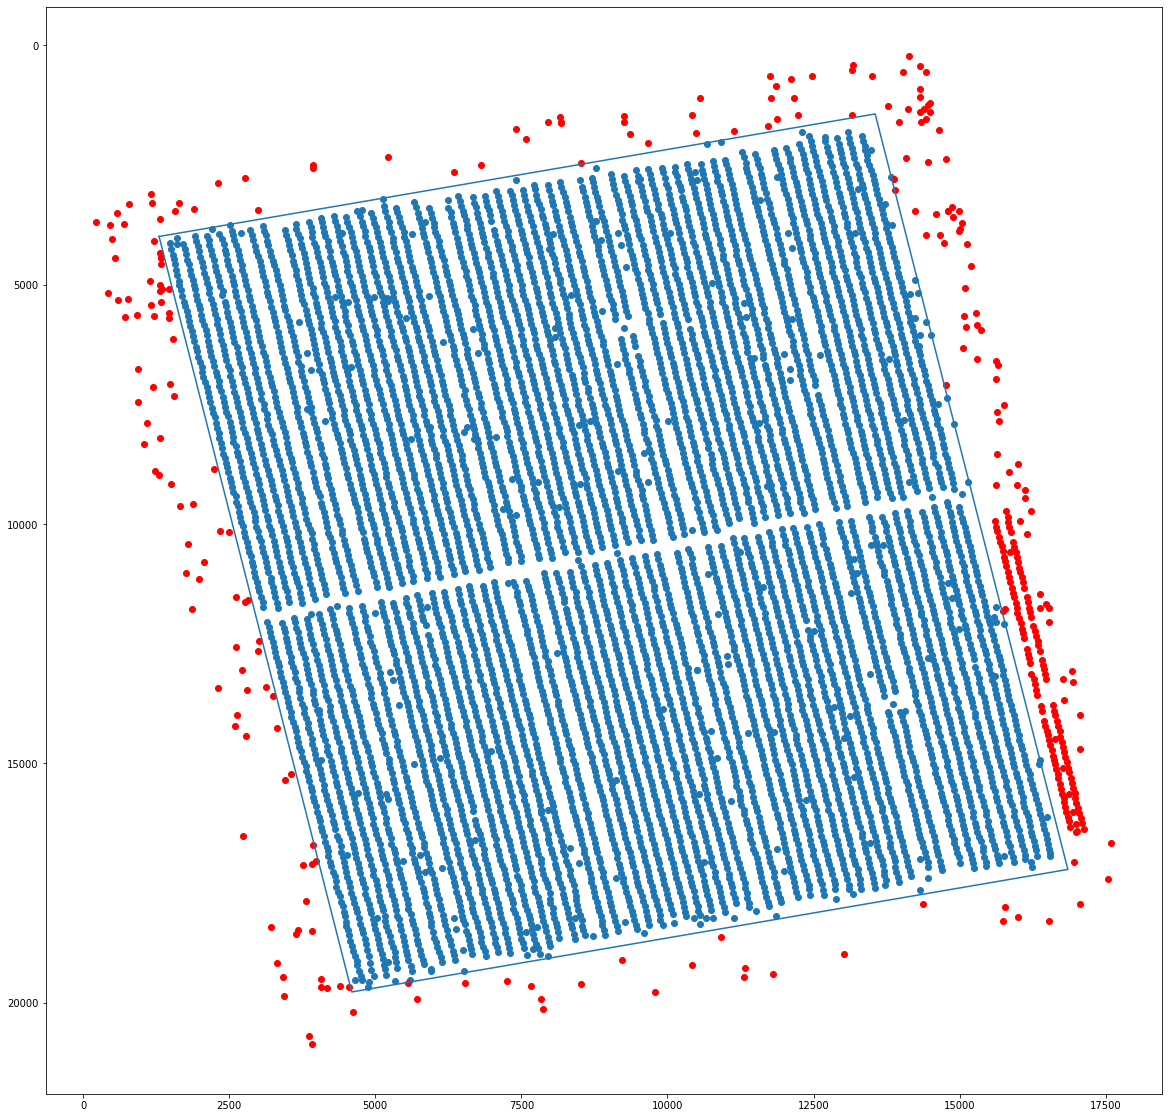

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.plot(*process_area_px.T)
ax.scatter(bbox_dom_in.xc, bbox_dom_in.yc)
ax.scatter(bbox_dom_out.xc, bbox_dom_out.yc, c='r')
ax.invert_yaxis()

plt.show()

In [30]:
with shapefile.Writer(f"{p2.root}/12_locate_by_yolo/first_test.shp") as shp:
    shp.field('name', 'C')
    for i in bbox_dom_in.index.values:
        x0 = bbox_dom_in.x_geo[i]
        y0 = bbox_dom_in.y_geo[i]

        shp.point(x0, y0)
        shp.record(str(i))

In [32]:
point0_hv = bbox_dom[['x0', 'y0']].values
point1_hv = bbox_dom[['x1', 'y1']].values

geo_xy0 = geotiff.pixel2geo(point0_hv, p4d.dom_header)
geo_xy1 = geotiff.pixel2geo(point1_hv, p4d.dom_header)

bbox_dom['x0_geo'] = geo_xy0[:,0]
bbox_dom['y0_geo'] = geo_xy0[:,1]

bbox_dom['x1_geo'] = geo_xy1[:,0]
bbox_dom['y1_geo'] = geo_xy1[:,1]

In [33]:
def save_shp(bbox, shp_path):
    with shapefile.Writer(shp_path) as shp:
        shp.field('name', 'C')
        for i in range(len(bbox)):
            x0 = bbox.x0_geo.iloc[i]
            y0 = bbox.y0_geo.iloc[i]
            x1 = bbox.x1_geo.iloc[i]
            y1 = bbox.y1_geo.iloc[i]

            coord = [[x0, y0],[x1, y0],[x1, y1],[x0, y1],[x0, y0]]
            shp.poly([coord])
            shp.record(str(i))

In [38]:
save_shp(bbox_dom_in, f'{p2.root}/12_locate_by_yolo/keep_bbox.shp')

In [39]:
save_shp(bbox_dom_out, f'{p2.root}/12_locate_by_yolo/rm_bbox.shp')

# sort roi id

In [41]:
root = shapefile.Reader(f"{p2.root}/10_locate_by_cv/color_label_0417_mavic/keep_points_manual.shp")
points_np = np.zeros((0,2))
for i, point in enumerate(root.shapes()):
    points_np = np.vstack([points_np, np.asarray(point.points)])

In [42]:
points_np

array([[ 368062.841475  , 3956058.770185  ],
       [ 368062.92601   , 3956058.50382   ],
       [ 368060.79828   , 3956058.438425  ],
       ...,
       [ 368077.83101933, 3956052.40406528],
       [ 368104.20374254, 3956032.55672578],
       [ 368068.25801574, 3956033.21494461]])

In [43]:
points_np_px = geotiff.geo2pixel(points_np, p4d.dom_header)

In [44]:
xu = process_area_px[1,:] - process_area_px[0,:]
yu = process_area_px[1,:] - process_area_px[2,:]

xu, yu

(array([12254, -2560]), array([ -3297, -15783]))

In [45]:
# 转换为单位向量
def vector_mod(Ax, By):
    return np.sqrt(np.sum(np.square([Ax, By])))

In [46]:
v1 = xu / vector_mod(*xu)
v2 = yu / vector_mod(*yu)

v1, v2

(array([ 0.97886729, -0.20449651]), array([-0.20448176, -0.97887037]))

In [47]:
cvtmat = np.vstack([v1, v2]).T
cvtmat

array([[ 0.97886729, -0.20448176],
       [-0.20449651, -0.97887037]])

In [48]:
cvt_xy = np.linalg.inv(cvtmat).dot(points_np_px.T).T
cvt_xy

array([[  1705.05339022,  -4323.02129442],
       [  1713.32755208,  -4410.56305633],
       [  1056.33137714,  -4293.74122808],
       ...,
       [  5896.61968579,  -7237.76952444],
       [ 12716.86003955, -15017.87562351],
       [  1729.07190339, -12511.962254  ]])

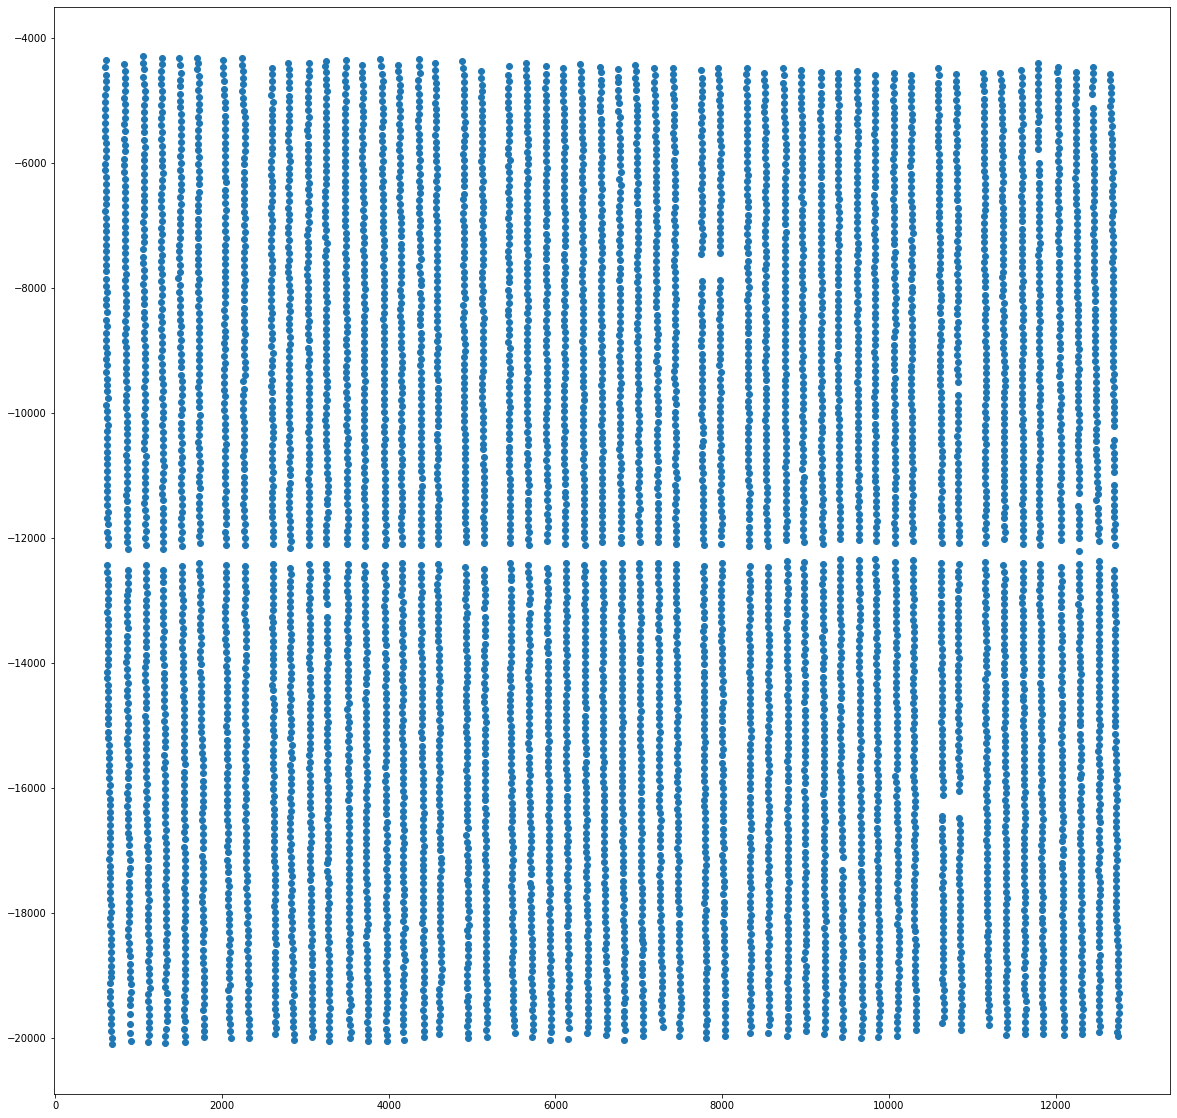

In [49]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.scatter(*cvt_xy.T)

plt.show()

# find the ridge

In [50]:
v, n = np.unique((cvt_xy[:,0] / 11).astype(int) * 11, return_counts=True)

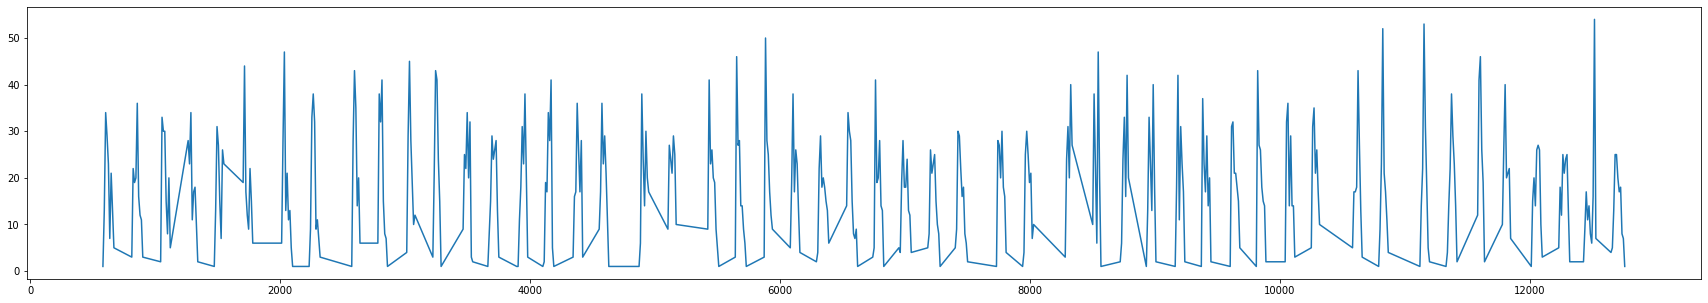

In [51]:
fig, ax = plt.subplots(1,1, figsize=(30,5))
ax.plot(v,n)
plt.show()

In [52]:
from scipy.signal import find_peaks

52


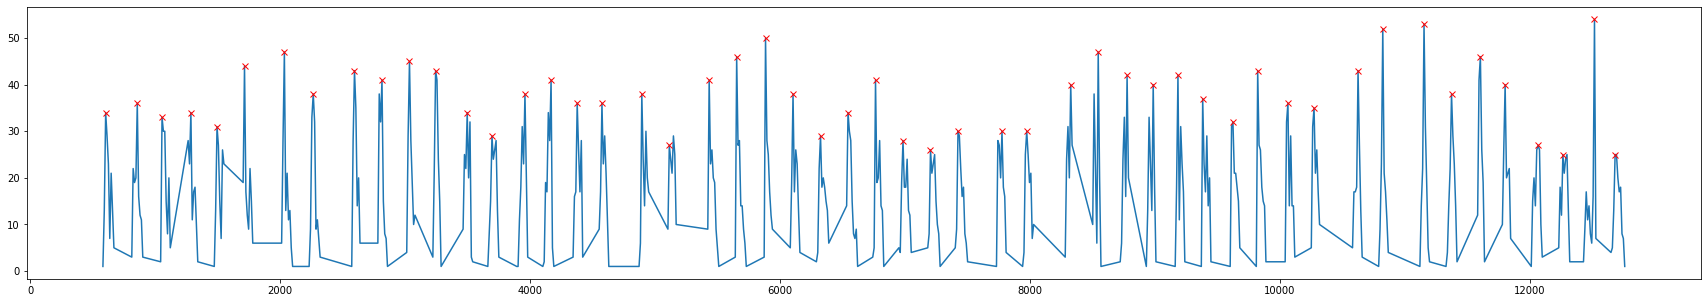

In [63]:
peaks, _ = find_peaks(n, distance=5, height=20)
print(len(peaks))

fig, ax = plt.subplots(1,1, figsize=(30,5))
ax.plot(v,n)
for i in peaks:
    ax.plot(v[i], n[i], 'rx')
    
plt.savefig("peak20.png")
plt.show()

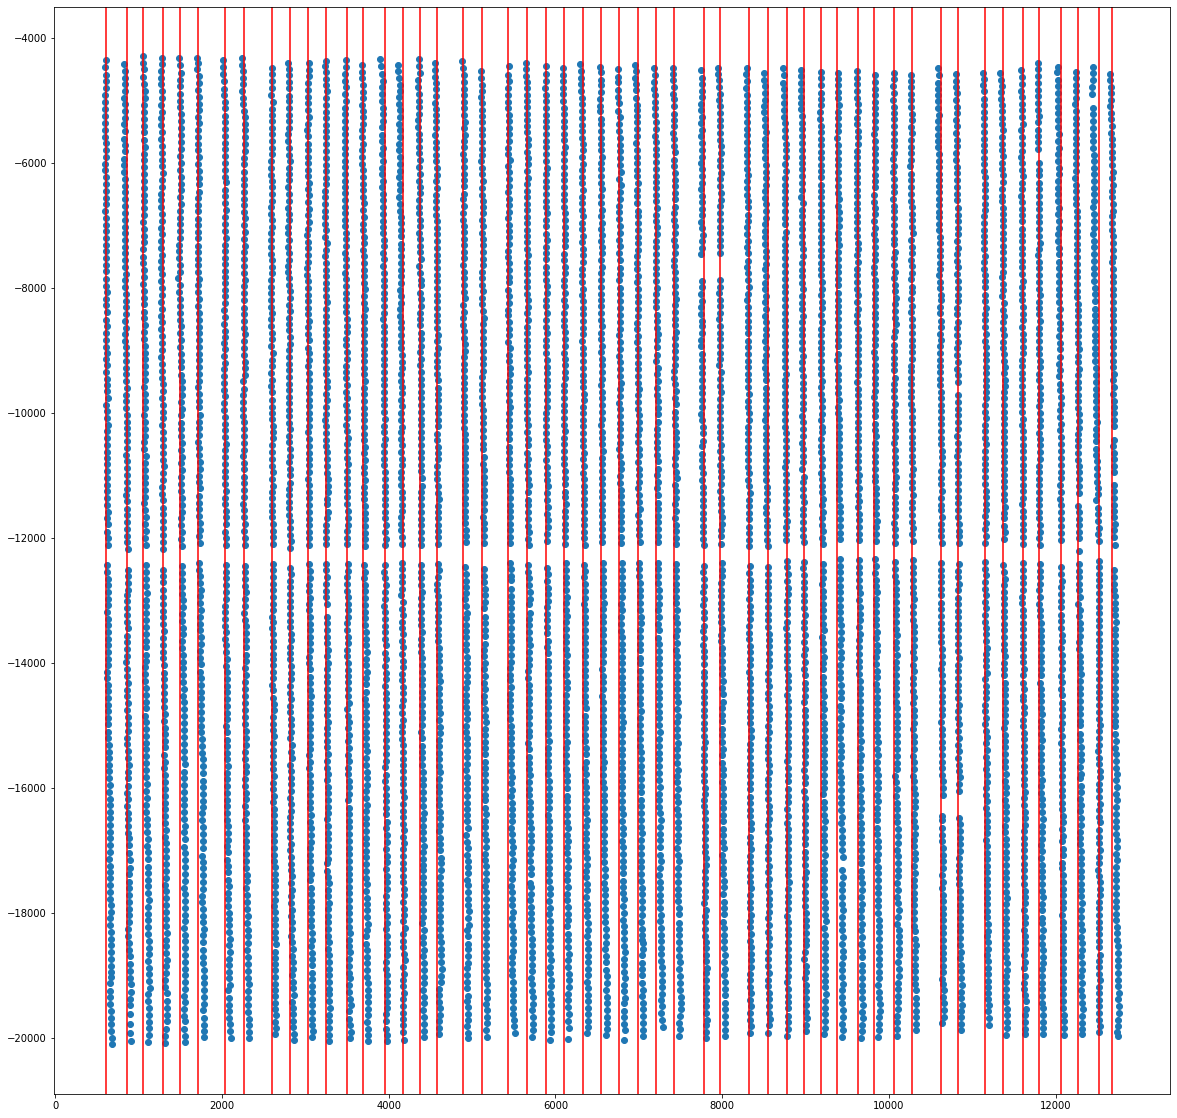

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.scatter(*cvt_xy.T, )

for i in peaks:
    ax.axvline(x=v[i],c='r')

plt.show()

In [55]:
peak_x = v[peaks]
peak_x

array([  605,   858,  1056,  1287,  1496,  1716,  2035,  2266,  2596,
        2816,  3036,  3245,  3498,  3696,  3960,  4169,  4378,  4576,
        4895,  5115,  5434,  5654,  5885,  6105,  6325,  6545,  6765,
        6985,  7205,  7425,  7777,  7975,  8327,  8547,  8778,  8987,
        9185,  9383,  9625,  9823, 10065, 10274, 10626, 10824, 11154,
       11374, 11605, 11803, 12067, 12265, 12518, 12683])

In [56]:
buffer = peak_x[1:] - peak_x[:-1]
buffer = np.append(buffer, buffer[-1])
buffer

array([253, 198, 231, 209, 220, 319, 231, 330, 220, 220, 209, 253, 198,
       264, 209, 209, 198, 319, 220, 319, 220, 231, 220, 220, 220, 220,
       220, 220, 220, 352, 198, 352, 220, 231, 209, 198, 198, 242, 198,
       242, 209, 352, 198, 330, 220, 231, 198, 264, 198, 253, 165, 165])

In [57]:
bro_pos = pd.DataFrame(columns=["x_geo", "y_geo", "x_pix", "y_pix", "x_cvt", "y_cvt"])

bro_pos["x_geo"] = points_np[:,0]
bro_pos["y_geo"] = points_np[:,1]
bro_pos["x_pix"] = points_np_px[:,0]
bro_pos["y_pix"] = points_np_px[:,1]
bro_pos["x_cvt"] = cvt_xy[:,0]
bro_pos["y_cvt"] = cvt_xy[:,1]

bro_pos

,x_geo,y_geo,x_pix,y_pix,x_cvt,y_cvt
0,368062.841475,3.956059e+06,2553,3883,1705.053390,-4323.021294
1,368062.926010,3.956059e+06,2579,3967,1713.327552,-4410.563056
2,368060.798280,3.956058e+06,1912,3987,1056.331377,-4293.741228
3,368061.570260,3.956058e+06,2155,4063,1278.656264,-4417.827795
4,368062.961100,3.956058e+06,2591,4065,1705.034784,-4508.946009
...,...,...,...,...,...,...
7532,368105.512510,3.956017e+06,15930,17051,12106.786568,-19948.295656
7533,368072.580440,3.956010e+06,5606,19233,1554.749621,-19972.962089
7534,368077.831019,3.956052e+06,7252,5879,5896.619686,-7237.769524
7535,368104.203743,3.956033e+06,15519,12100,12716.860040,-15017.875624


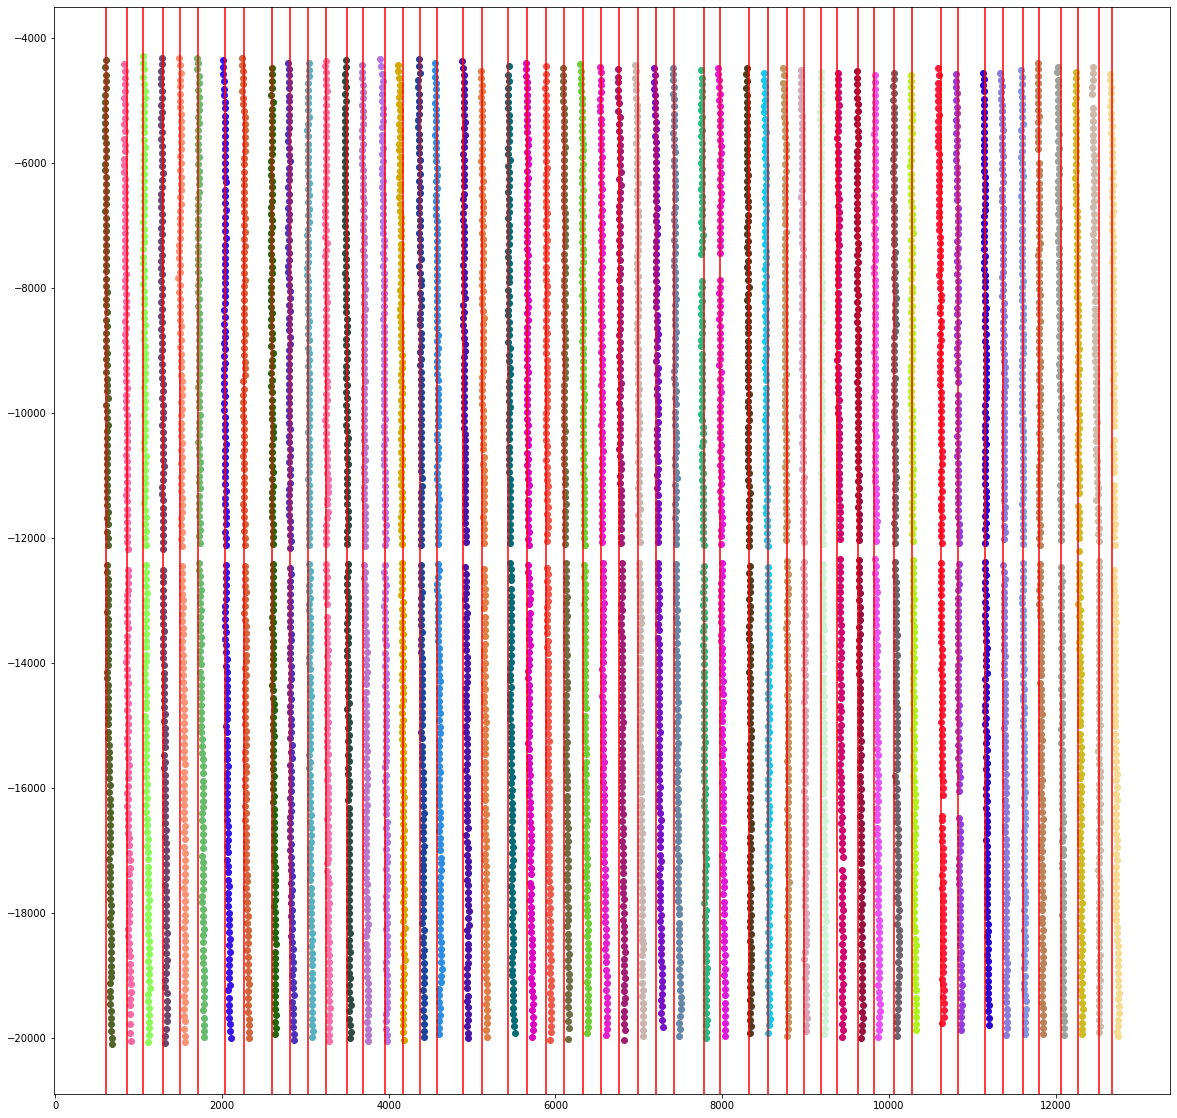

In [62]:
#buffer_ratio = 0.5
buffer_ratio = buffer.mean() * 0.53
fid_st = 1
bro_pos['fid'] = -1

fig, ax = plt.subplots(1,1, figsize=(20,20))

for i in peaks:
    ax.axvline(x=v[i],c='r')

for i in peak_x:
    range_st = i - buffer_ratio
    range_ed = i + buffer_ratio
    
    selected = (bro_pos.x_cvt >= range_st ) & (bro_pos.x_cvt <= range_ed) & (bro_pos.fid == -1)
    
    selected_xy = bro_pos.loc[selected, ['x_cvt', 'y_cvt']]
    
    color=np.random.rand(3)
    
    
    # remove outlier and sort by Y axis
    selected_xy = selected_xy.sort_values(by=['y_cvt'], ascending=False)
    fid = np.linspace(fid_st, len(selected_xy)+fid_st-1, num=len(selected_xy)).astype(int)
    
    selected_xy['fid'] = fid
    bro_pos.loc[selected_xy.index, 'fid'] = selected_xy.fid
    
    fid_st += len(selected_xy)
    
    ax.scatter(selected_xy.x_cvt, selected_xy.y_cvt, color=color)

plt.savefig("ridge20.png")
plt.show()